In [1]:
import glob
import numpy as np
import pandas as pd
import xarray as xr 
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from matplotlib import animation, rc

plt.rcParams['text.usetex'] = True
plt.rcParams['animation.html'] = 'jshtml'

def make_colorbar(mf_dataset):
    #---------------------------------------------------------------------------
    # For Seting up the colorbar:
    #    - http://csc.ucdavis.edu/~jmahoney/matplotlib-tips.html
    #---------------------------------------------------------------------------
    cmap = cm.plasma
    norm = mcolors.Normalize(vmin=np.min(mf_dataset.Delta_MB),
                                  vmax=np.max(mf_dataset.Delta_MB))

    s_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    s_map.set_array(mf_dataset.Delta_MB)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (mf_dataset.Delta_MB[1] - mf_dataset.Delta_MB[0]) / 2.0
    bounds   = np.linspace(mf_dataset.Delta_MB[0]   - halfdist,
                           mf_dataset.Delta_MB[-1]  + halfdist,
                           len(mf_dataset.Delta_MB) + 1)

    return cmap, norm, s_map, bounds

# Plot Synthetic Geometry 

In [ ]:
bed  = np.loadtxt('../../input_data/lilk-a_bed.dat')
surf = np.loadtxt('../../input_data/lilk-a_surf.dat')


fig, ax = plt.subplots(1,1,figsize=(10, 5))

ax.plot( bed[::-1,0] / 1e3,  bed[:,1], 'k' , label='Bed')
ax.plot(surf[::-1,0] / 1e3, surf[:,1], 'k:', label='Surface')
ax.legend()

ax.fill_between(bed[::-1,0] / 1e3, bed[:,1], surf[:,1], color='lightblue')
ax.fill_between(bed[::-1,0] / 1e3, bed[:,1].min()*np.ones_like(bed[:,1]), 
                bed[:,1], color='saddlebrown', alpha=0.5)

ax.set_xlim(0, bed[:,0].max() / 1e3)
ax.set_ylim(bed[:,1].min(), None)

ax.set_ylabel('Elevation [m a.s.l.]')
ax.set_xlabel('Distance along flowline [km]')

fig.savefig('./figs/synth_geom.png', dpi=300,
            bbox_inches='tight', facecolor='w')

# Mass Balance Gridsearch

In [ ]:
sources = []

for fp in sorted(glob.glob("./nc/relax_*.nc")):
    with xr.open_dataset(fp) as src: 
        src["Z"]     = src.zbed + src.Z * src.height 
        src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)
        sources.append(src)
    
mf_dataset = xr.concat(sources,
                       pd.Index(data = np.linspace(2000, 2500, 11),
                                name = 'Delta_MB'))

Vol = mf_dataset.isel(coord_2=-1).height.integrate('coord_1') / \
      mf_dataset.isel(coord_2=-1, t=0).height.integrate('coord_1')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

# Make a colormap and all the associated var names
cmap, norm, s_map, bounds = make_colorbar(mf_dataset)
    
for delta_mb in Vol.Delta_MB:
    color = cmap(norm(delta_mb))
    ax.plot(Vol.t, Vol.sel(Delta_MB=delta_mb), color=color)

ax.axhline(1.0,c='k',ls=':',lw=1, alpha=0.5)

cbar = fig.colorbar(s_map,
                spacing='proportional',
                ticks=mf_dataset.Delta_MB,
                ax=ax,
                boundaries=bounds,
                drawedges=True,
                format='%2.0f')

# annotate the figures axes
ax.set_ylabel('Relative Volume per Unit Width (km$^2$)')
ax.set_xlabel('Time (a)')
# annotate the colorbar axes
cbar.set_label('$A_{\\rm mean}$ (kg m$^{-2}$ yr$^{-1}$)', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=7)

fig.tight_layout()


fig.savefig('./figs/A_mean_gridsearch.png',
            dpi=400, 
            bbox_inches='tight',
            facecolor='w')

In [ ]:
# subset the nc of all the nc's
spinup = mf_dataset.sel(Delta_MB=2150).isel(t=slice(0,-1,5))

fig, ax = plt.subplots(figsize=(9,3), constrained_layout=True)

vmin = spinup["vel_m"].min()
vmax = spinup["vel_m"].max()

contour_opts = {'levels' : np.linspace(vmin, vmax, 101),
                'vmin'   : vmin, 
                'vmax'   : vmax,
                'cmap'   : 'magma'}

# Plot the initial condition
cax = ax.contourf(spinup.X[::-1,:], 
                  spinup.Z.isel(t=0),
                  spinup["vel_m"].isel(t=0),
                  **contour_opts)
# Set up the colorbar
cbar = fig.colorbar(cax, 
                    ticks = np.linspace(0, 150.0, 4))
cbar.set_label('Velocity [m yr$^-1$]', rotation=270, labelpad=20)

# Set axis limits for whole animation
ax.set(xlim=(None,20e3), ylim=ax.get_ylim())
# Add time annotation
label = ax.text(0.05, 0.9, r"$t=0$",
                transform=ax.transAxes,
                ha='center', va='center')
plt.close()

def animate(i):
    # Wipe the axis
    ax.collections = []
    # Plot the contour
    ax.contourf(spinup.X[::-1,:], 
                spinup.Z.isel(t=i),
                spinup["vel_m"].isel(t=i),
                **contour_opts)
    # Update time annotation
    label.set_text("$t={{{:6.1f}}}$".format(spinup.t[i].values))
    
anim = animation.FuncAnimation(
    fig, animate, interval=150, frames=len(spinup.t)-1)
#fig.tight_layout()

anim.save('./figs/uncoupled_spinup.mp4', dpi=400)

In [ ]:
plt.rcParams['text.usetex'] = False
mf_dataset.isel(coord_2=-1).height.integrate('coord_1').sel(Delta_MB=2150).differentiate('t').plot()
plt.yscale('log')

# S.S. Thermal Strcutre

In [2]:
sources = []

for fp in sorted(glob.glob("./nc/heat_sources_*.nc")):
    with xr.open_dataset(fp) as src: 
        src["Z"]     = src.zbed + src.Z * src.height 
        src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)
        sources.append(src)
    
heat_sources = xr.concat(sources, 
                         pd.Index(data = [f'Step{i+1}' for i in range(len(sources))],
                                  name = 'step'))

In [3]:
sorted(glob.glob("./nc/heat_sources_*.nc"))

['./nc/heat_sources_step1.nc', './nc/heat_sources_step2.nc']

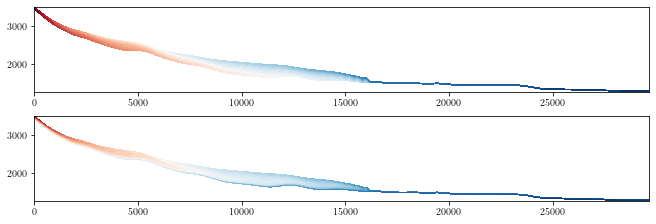

In [4]:
fig, ax = plt.subplots(2,1,figsize=(9,3), constrained_layout=True)


im = ax[0].contourf(heat_sources.sel(step='Step1').X[::-1,:], 
                    heat_sources.sel(step='Step1').Z.isel(t=0),
                    heat_sources.sel(step='Step1')["temperature"].sel(t=16),
                    levels=51,
                    cmap = 'RdBu')

im = ax[1].contourf(heat_sources.sel(step='Step2').X[::-1,:], 
                    heat_sources.sel(step='Step2').Z.isel(t=0),
                    heat_sources.sel(step='Step2')["temperature"].sel(t=29),
                    levels=51,
                    cmap = 'RdBu')

# label = ax[0].text(0.05, 0.9, r"Dirichlet B.C. at surface",
#                 transform=ax[0].transAxes)
#                 #ha='center', va='center')

# ax[0].set(xlim=(None,20e3), ylim=ax[0].get_ylim())

# cbar = fig.colorbar(im)
    
# cbar.set_label('Temperature [ $^{\circ}$C ]', rotation=270, labelpad=15)

# fig.savefig('./figs/temp_step1.png',
#             dpi=300, bbox_inches='tight', 
#             facecolor='w')

In [ ]:
heat_sources.sel(step='Step1').temperature.t